# Introduction

This notebook provides everything you need to use the swap test to approximate a quantum state. After the necessary functions are introduced, you're encouraged to modify target state and optimizer parameters to observe performance. I'll try to provide some reasoning for my code choices throughout.

# General imports (run this cell before everything else!)

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *

# Part 1 - Generating quantum states

Before we begin, we can verify that Qiskit's quantum gate set can generate any single-qubit state starting from |0>. We do this with a u-gate, specified by angles θ and φ. 

We can visualize this as rotating |0> about the y-axis by θ radians, followed by a rotation of φ radians about the z-axis. In practice, Qiskit initializes multi-qubit states under the hood by constructing a block diagonal matrix, each block being a product of Y- and Z-rotations for the associated qubit (check the references in the readme for the source on that).

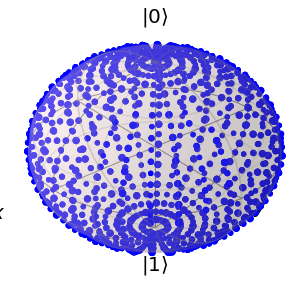

<Figure size 360x360 with 0 Axes>

In [28]:
### Verification - Does the u-gate cover the Bloch sphere? ###
# Code source: http://qutip.org/docs/latest/guide/guide-bloch.html#animating-with-the-bloch-sphere

from math import pi
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from qutip import Bloch, Qobj
%matplotlib inline

fig = plt.figure()
ax = Axes3D(fig,azim=-40,elev=30)
sphere = Bloch(axes=ax)
sphere.point_color = ['b']
sphere.point_marker = ['o']
sphere.point_size = [20, 27, 30, 40]
sphere.zlpos = [1.5, -1.5]
sphere.xlpos = [1.5, -1.5]

def animate(i, num_iters, backend):
    states = []
    for j in range(num_iters):
        qc = QuantumCircuit(1)
        qc.u((i/num_iters)*pi, (j/num_iters)*2*pi, 0, 0)
        states.append(Qobj(execute(qc, backend).result().get_statevector()))
    sphere.add_states(states, kind='point')
    sphere.make_sphere()
    return ax

# I think a random sampling until sphere coverage would have been more aesthetically pleasing, 
# but it was too time-consuming to generate. 
num_iters = 30
ani = FuncAnimation(fig, animate, fargs=(num_iters, Aer.get_backend('statevector_simulator')), frames=np.arange(num_iters))
ani.save('bloch_sphere.mp4', fps=15)

# Part 2 - Swap test implementation and state approximation

Now we introduce a proper quantum circuit. The cell below is an outline for the swap circuit, with u-gates tacked on at the front to initialize our qubits. 

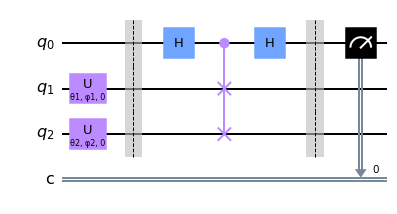

In [9]:
### The basic swap test circuit ###

theta1 = Parameter('θ1')
phi1 = Parameter('φ1')
theta2 = Parameter('θ2')
phi2 = Parameter('φ2')

qc = QuantumCircuit(3, 1)
qc.u(theta1, phi1, 0, 1)
qc.u(theta2, phi2, 0, 2)
qc.barrier()
qc.h(0)
qc.cswap(0, 1, 2)
qc.h(0)
qc.barrier()
qc.measure(0, 0)
qc.draw('mpl')

As mentioned in the readme, this circuit separates the original state into four components prior to measurement. Two of these components have the ancilla in the |1> state, two have it in |0>; the probability of measuring |1> is related to the inner product of the input states. If the states are parallel, we always measure 0 (useful for product states later). Otherwise, there's a nonzero chance of measuring 1. There's a vanishingly small chance of non-parallel states returning a 1 measurement after repeated trials, so the appropriate approach is to run this circuit multiple times for verification. 

But we can do more. Addressed in the readme, collecting measurement results from running the circuit many times allows us to approximate the inner product of the two states. 

Below are the functions we'll use to run the swap test multiple times and approximate the inner product. This circuit is parametrized by the Bloch angles of our two states.

In [34]:
### Swap test functions ###

def angles_to_amplitudes(state):
    ''' Convert the Bloch angle representation of STATE to the amplitude representation. '''
    qc = QuantumCircuit(1)
    qc.u(state[0], state[1], 0, 0)
    
    backend = Aer.get_backend('statevector_simulator')
    job = execute(qc, backend)
    result = job.result()
    return result.get_statevector()

def swap_test(state1, state2, backend, num_shots=1024):
    ''' Performs the swap test on STATE1 and STATE2 a total of NUM_SHOTS times. '''
    qc = QuantumCircuit(3, 1)
    qc.h(0)
    qc.u(state1[0], state1[1], 0, 1)
    qc.u(state2[0], state2[1], 0, 2)
    qc.cswap(0, 1, 2)
    qc.h(0)
    qc.measure(0, 0)
        
    job = execute(qc, backend, shots=num_shots)
    counts = job.result().get_counts()
    if '1' in counts:
        return counts['1']
    else:
        return 0
    
def inner_product_approx(state1, state2, backend, num_shots=1024):
    ''' Returns an approximation to the inner product of STATE1 and STATE2 using the swap test. '''
    counts = swap_test(state1, state2, backend, num_shots)
    return 1 - ((2 / num_shots)*counts)

def inner_product_exact(state1, state2):
    ''' Calculating the exact inner product of STATE1 and STATE2. '''
    state1 = angles_to_amplitudes(state1)
    state2 = angles_to_amplitudes(state2)
    return np.abs(np.dot(np.conjugate(state1), state2))**2

Simulators for a single qubit (relatively speaking), but we don't want to overdo it later. 1024 shots is one thing, but 4096? 16000? These numbers will slow our optimization procedure to a crawl if we have to run them every iteration. Furthermore, it's wasteful and possibly unnecessary. So for a handful of input states and target states we'll observe how many shots it takes to approximate the inner product sufficiently well.

In [36]:
### Swap test convergence tests ###

from random import seed, uniform
from math import pi
import matplotlib.pyplot as plt
seed(42)

def swap_test_convergence(state1, state2, backend, max_shots=2**11, num_trials=100, num_repeats=10):
    ''' Compute the inner product of STATE1 and STATE2 for multiple shot values. '''
    exact_ip = inner_product_exact(state1, state2)
    trials = []
    shot_range = np.linspace(1, max_shots, num_trials)
    for shot_cnt in shot_range:
        repeats = []
        for i in range(num_repeats):
            repeats.append(inner_product_approx(state1, state2, backend, num_shots=shot_cnt))
        trials.append(repeats)
    return exact_ip, shot_range, np.array(trials)

qasm_backend = Aer.get_backend('qasm_simulator')

### First test: Orthogonal states ###

zero = [0, 0]
one = [pi, 0]
results_orth = swap_test_convergence(zero, one, qasm_backend)


### Second test: |0> and |+> ###

plus = [pi/2, 0]
results_plus = swap_test_convergence(zero, plus, qasm_backend)

### Third test: A random state ###

rstate1 = [uniform(0, pi), uniform(0, 2*pi)]
rstate2 = [uniform(0, pi), uniform(0, 2*pi)]
results_random = swap_test_convergence(rstate1, rstate2, qasm_backend)





Next comes the challenge. Given a randomly generated single-qubit quantum state, I want generate the same state in a qubit of my own. 

By making multiple runs of the swap test we can approximate the inner product of the two states. This inner product will be used as a cost function for our optimizer, which will tune the (theta, phi) parameters of our input state until we reach the target state. 

In creating  

In [26]:
### Approximating a single-qubit quantum state ###

from scipy.optimize import minimize, brute, differential_evolution, dual_annealing
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector

def cost(init_state, *args):
    return -1*inner_product_approx(init_state, args[0], args[1], args[2])

def states_for_plotting(target_state, output_state):
    qc = QuantumCircuit(2)
    qc.u(target_state[0], target_state[1], 0, 0)
    qc.u(output_state[0], output_state[1], 0, 1)
    state_backend = Aer.get_backend('statevector_simulator')
    return execute(qc, state_backend).result().get_statevector()

initial_state = [0, 0] # CHANGEME
target_state = [uniform(0, pi), uniform(0, 2*pi)] # CHANGEME
backend = Aer.get_backend('qasm_simulator')
parameter_range = ((0, pi), (0, 2*pi))
print("Target state was θ = " + str(target_state[0]) + ", Φ = " + str(target_state[1]))

### Brute force minimization ###

print("TESTING: Brute force search (grid search)")

approx_state_brute = brute(cost, ranges=parameter_range, args=(target_state, backend, 1024), Ns=50)
print("State minimising cost: θ = " + str(approx_state_brute[0]) + ", Φ = " + str(approx_state_brute[1]))

statevector_brute = states_for_plotting(target_state, approx_state_brute)

### Differential evolution ###

print("TESTING: Differential evolution")

approx_state_de = differential_evolution(cost, bounds=parameter_range, args=(target_state, backend, 1024))
approx_state_de = approx_state_de.get('x')
print("Approximate state: θ = " + str(approx_state_de[0]) + " rad, Φ = " + str(approx_state_de[1]) + " rad.")


### Dual annealing ###
print("TESTING: Dual annealing search")

approx_state_da = dual_annealing(cost, parameter_range, args=(target_state, backend, 1024))
approx_state_da = approx_state_da.get('x')
print("State minimising cost: θ = " + str(approx_state_da[0]) + " rad, Φ = " + str(approx_state_da[1]) + " rad.")

Target state was θ = 0.3687245438091045, Φ = 3.677328302376183
TESTING: Brute force search (grid search)
State minimising cost: θ = 0.20195952773077244, Φ = 3.5326888818938285
TESTING: Differential evolution
Approximate state: θ = 0.359200025876778 rad, Φ = 3.4877922458822006 rad.
TESTING: Dual annealing search
State minimising cost: θ = 0.2712333361647552 rad, Φ = 3.468505241741063 rad.


In [ ]:
### Benchmarking performance of global optimizers ###



# Part 3 - Using the swap test for product states 

With the single-qubit case out of the way, we next turn to what ends up being a simpler problem. Consider a multi-qubit state, but take out all the complexity: a product state where all the qubits are either |0> or |1>, like |01001>. Kind of like a quantum bit string. 

If we're given a state like this and asked to match it, we don't have to deal with the optimizing procedure used above. Look at it in a qubit-by-qubit fashion, and consider the first qubit of our target state. If the first qubit of our initial state matches the target qubit, we will never measure 1 off the ancilla qubit (assuming a perfect quantum computer, but let's not go into the weeds here). If they don't match, we'll eventually get a 1, and we modify our qubit to match. 

That's a lot of words to say that we can just iterate through the qubits in our initial state, using grid search until we achieve a perfect match. 

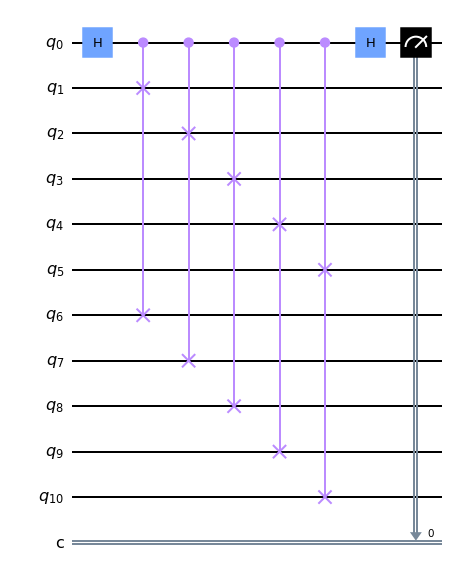

In [4]:
### Constructing a better swap circuit ###

state_size = 5
qc = QuantumCircuit(2*state_size + 1, 1)
qc.h(0)
for i in range(1, state_size + 1):
    qc.cswap(0, i, i + state_size)
qc.h(0)
qc.measure(0, 0)
qc.draw('mpl')

This circuit performs the same function as in the single-qubit case, except we now apply a controlled-swap gate on a qubit-by-qubit basis. If you compute the measurement probabilities for the ancilla qubit, you'll find the same expression as the single-qubit swap test.

Since we're dealing with a simple kind of product state, brute force is more valid option here. We search through all possible bit strings until we find a match. If our swap test returns a 1 in N runs of the swap test circuit, we'll know that one of the qubits is incorrectly set. There's a vanishingly small chance that the swap test will return a 0 for several thousand runs.

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister
from itertools import product

initial_state = (0, 0, 0, 0)
target_state  = (1, 1, 0, 1)

def bitlist2int(bit_list):
    s = map(str, bit_list)
    s = ''.join(s)
    return int(s, base=2)

# Swap test for multiple qubits
def swap_test_mq(state1, state2, backend, num_shots=1024):
    n = len(state1)
    q = QuantumRegister(2*n+1)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    
    state1_reg = np.zeros(2**n)
    state1_reg[bitlist2int(state1)] = 1
    state2_reg = np.zeros(2**n)
    state2_reg[bitlist2int(state2)] = 1
    
    qc.initialize(state1_reg, q[1:n+1])
    qc.initialize(state2_reg, q[n+1:])
    qc.h(0)
    for i in range(1, n+1):
        qc.cswap(0, i, i+n)
    qc.h(0)
    qc.measure(0, 0)
    
    job = execute(qc, backend, shots=num_shots)
    counts = job.result().get_counts()
    if '1' in counts:
        return (counts['1'] != 0)
    else:
        return 0

qasm_backend = Aer.get_backend('qasm_simulator')
num_shots=128
def grid_search(target_state, backend, num_shots):
    bitstrings = product([0, 1], repeat=len(target_state))
    for state in bitstrings:
        if swap_test_mq(state, target_state, backend, num_shots) == 0:
            return state
    return "Sorry nothing"

grid_search((1, 1, 1, 1), qasm_backend, num_shots=128)